In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, hyperparameters):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

        # fix hyperparameters 
        self.covar_module.base_kernel.lengthscale = hyperparameters['lengthscale'] 
        self.covar_module.outputscale = hyperparameters['outputscale']
        self.covar_module.base_kernel.noise = hyperparameters['noise']

        self.covar_module.base_kernel.raw_lengthscale.requires_grad = False
        self.covar_module.raw_outputscale.requires_grad = False
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 2D dataset:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples = 100
input_dim = 2
# torch.manual_seed(0)

lengthscale = torch.tensor([0.5, 0.3], device=device)
outputscale = torch.tensor(1.8, device=device)
noise = 0.1

hyperparameters = {
    'lengthscale': lengthscale,
    'outputscale': outputscale,
    'noise': noise
}



In [4]:
train_x_np = np.random.uniform(low=-2.0, high=2.0, size=(num_samples, 2))
train_x = torch.tensor(train_x_np, dtype=torch.float32, device=device)

x1 = 4.0 * train_x_np[:, 0] - 2.0
x2 = 4.0 * train_x_np[:, 1] - 2.0

fact1a = (x1 + x2 + 1)**2
fact1b = 19 - 14*x1 + 3*x1**2 - 14*x2 + 6*x1*x2 + 3*x2**2
fact1 = 1 + fact1a * fact1b

fact2a = (2*x1 - 3*x2)**2
fact2b = 18 - 32*x1 + 12*x1**2 + 48*x2 - 36*x1*x2 + 27*x2**2
fact2 = 30 + fact2a * fact2b

prod = fact1 * fact2

train_y_np = (np.log(prod) - 8.693) / 2.427

train_y = torch.tensor(train_y_np, dtype=torch.float32, device=device)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise
likelihood.raw_noise.requires_grad = False

kernel = gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)
kernel.lengthscale = lengthscale
kernel.outputscale = outputscale

model = ExactGPModel(train_x, train_y, likelihood, kernel, hyperparameters)

model.to(device)
likelihood.to(device)


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [6]:
# print model hyperparameters
if model.covar_module.base_kernel.lengthscale.numel() > 1:
        print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.cpu().detach().numpy())  # Print all lengthscale values
else:
    print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.item())  # Print single lengthscale value

print(f"Outputscale:", model.covar_module.outputscale.item())
print(f"Noise:", model.likelihood.noise.item())

Lengthscale: [[0.49999997 0.30000004]]
Outputscale: 1.7999999523162842
Noise: 0.09999999403953552


In [7]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

shape of grid points tensor: torch.Size([32400, 2])


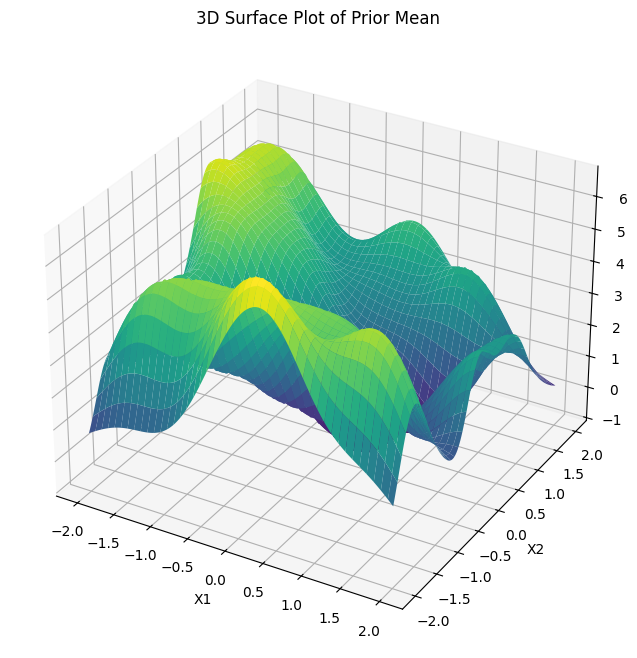

In [30]:
# plot a 3d surface of the prior
x1_range = np.linspace(-2, 2, 180)
x2_range = np.linspace(-2, 2, 180)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid_points = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T

test_x = torch.tensor(grid_points, dtype=torch.float32, device=device)  

print("shape of grid points tensor:", test_x.shape)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prior_grid = model(test_x)
    test_y = prior_grid.mean.cpu().numpy().reshape(x1_grid.shape)
    prior_variance = prior_grid.variance.cpu().numpy().reshape(x1_grid.shape)

# plot the prior mean
fig = plt.figure(figsize=(10, 8))   
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid, x2_grid, test_y, cmap='viridis', edgecolor='none')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Prior Mean')
ax.set_title('3D Surface Plot of Prior Mean')
plt.show()

In [31]:
# save this dataset test_x and test_y as csv files
np.savetxt("dataset1x_2d_32400.csv", test_x.cpu().numpy(), delimiter=",")

test_y = test_y.flatten()
np.savetxt("dataset1y_2d_32400.csv", test_y, delimiter=",")

In [32]:
# load the dataset from csv files
loaded_test_x = np.loadtxt("dataset1x_2d_32400.csv", delimiter=",")
loaded_test_y = np.loadtxt("dataset1y_2d_32400.csv", delimiter=",")

print("Loaded test_x shape:", loaded_test_x.shape)
print("Loaded test_y shape:", loaded_test_y.shape)

Loaded test_x shape: (32400, 2)
Loaded test_y shape: (32400,)


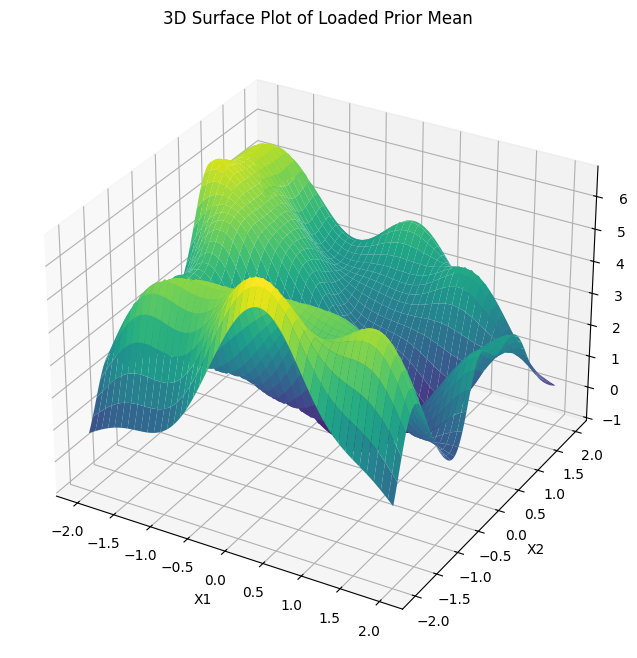

In [33]:
# plot the loaded dataset
loaded_test_x = torch.tensor(loaded_test_x, dtype=torch.float32, device=device)
loaded_test_y = torch.tensor(loaded_test_y, dtype=torch.float32, device=device)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(loaded_test_x[:, 0].cpu().numpy().reshape(x1_grid.shape), 
               loaded_test_x[:, 1].cpu().numpy().reshape(x2_grid.shape), 
               loaded_test_y.cpu().numpy().reshape(x1_grid.shape),
               cmap='viridis', edgecolor='none')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Prior Mean')
ax.set_title('3D Surface Plot of Loaded Prior Mean')
plt.show()